<a href="https://colab.research.google.com/github/crazylazylife/AstronomicalDataAnalysis-Kaggle_LSST_Data_Challenge-/blob/master/Data_Mining_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PLAsTiCC Astronomical Classification
PLAsTiCC is intended to simulate sources that vary with time in the night-sky as seen during the first three years of operation of the Large Synoptic Survey Telescope (LSST).

The LSST (illustrated below) is a telescope with an 8.4 meter primary mirror diameter being built high up in Atacama desert of Chile, on a mountain called Cerro Pachon. The telescope is going to have a 3.2 gigapixel camera that's about the size of an adult human to take images of the night sky. This large FoV is what makes LSST so revolutionary. If you like photography, LSST has a 6.5 meter effective aperture and a focal ratio of f/# of 1.23.

This means that LSST can make a map of the entire southern sky, resolving details that are smaller than the width of a human hair held at arm's length... every 4 nights. That's a data rate of 20--40 terabytes, or about 1 US Library of Congress every night. It is, for want of a better word, ginormous.

The difference is even more stark when compared against telescopes that are both smaller and have smaller FoVs - like most everything astronomers have access to now.

![LSST to be built](http://www.kavlifoundation.org/sites/default/files/image/resources/2015-SL_LSST_LSSTIllus.jpg)

**Importing all the necessary libraries**
All necessary libraries to be imported should be listed in the cell-->

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

#Importing libraries for classification
%tensorflow_version 1.x
import sys
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import GRU, Dense, Activation, Dropout, CuDNNGRU, concatenate, Input, BatchNormalization, Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from collections import Counter

sns.set_style('whitegrid')
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)

Using TensorFlow backend.


This is the code for importing the complete dataset from Kaggle to Colabs. However, we do not initially need the complete 12GB of data for our analysis. So we shall upload the small training files initially for the job.

In [0]:
"""
#Steps to import the dataset from Kaggle to Colab. Always execute this block. Commented for initial Data
#Analysis Part
#Don't forget to download the API Token
#Installing Kaggle
!pip install -U kaggle
#Make a directory name dKaggle
!mkdir -p ~/.kaggle
#Upload the kaggle.json file
from google.colab import files
files.upload()
#Copy the json file to the Kaggle directory
!cp kaggle.json ~/.kaggle/
#Import the dataset. This usually takes a lot of time. The total dataset is >13GB
!kaggle competitions download -c PLAsTiCC-2018
#Unzip the required file
!unzip "training_set.csv.zip"
!unzip "training_set_metadata.csv"
!ls
"""

In [4]:
#Test cell for now to check if the csv is loaded corretly. Will remove it later
training_data = pd.read_csv("training_set.csv")
print("Training Data: ")
print(training_data.head())
print(training_data.shape)
print("\nTraining Metadata: ")
training_metadata = pd.read_csv("training_set_metadata.csv")
print(training_metadata.head())
print(training_metadata.shape)

#Converting int-datatype attribute 'ddf_bool' to float-datatype
training_metadata['ddf'] = training_metadata['ddf'].astype(float)

Training Data: 
   object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1
(1421705, 6)

Training Metadata: 
   object_id          ra       decl  ...  distmod  mwebv  target
0        615  349.046051 -61.943836  ...      NaN  0.017      92
1        713   53.085938 -27.784405  ...  45.4063  0.007      88
2        730   33.574219  -6.579593  ...  40.2561  0.021      42
3        745    0.189873 -45.586655  ...  40.7951  0.007      90
4       1124  352.711273 -63.823658  ...  40.4166  0.024      90

[5 rows x 12 columns]
(7848, 12)


#Here we perform some basic Data Analysis on the training data.
But first, we need to understand the data we are dealing with. The various attributes of the dataset that will be used for the task of classification are described here:

Discussion on the training dataset containing the time series data.
1. mjd : It denotes the time, LSST took the image. The LSST takes an image of the patch of the sky for around 15-30 seconds, twice on the same day, which will be combined to remove "spurious glitches". This will follow for a number of days, each with different passbands. 'mjd' stands for Modified Julian Date - simply the number of decimal days from midnight on November 17, 1858.

2. passband : It denotes the passband that the observation at time mjd was taken. The mapping of the passband name to integer is quite straightforward and already done. The corresponding waveforms are also mentioned.
        {u→0, g→1, r→2, i→3, z→4, y→5}
        u -> ultraviolet
        g -> the visible portion blue/green
        r -> red
        i -> infrared
        z -> microwave
        y -> radiowave

3. flux : This contains the actual photometry - the measurements of the brightness of the source object as a function of time. The flux can be both positive or negative, which is based on comparison to a template flux. The flux can also have zero value, when the source will fade over time.

4. flux-err : The 68% confidence interval of the measurement of flux


We also have another dataset, containing metadata about some of the astronomical objects observed by LSST. They contain contextual information that might help in classification along with the light curve. The various attributes of this dataset is discussed here:

1. object_id : An unique number to identify the astronomical object surveyed and corresponds to the object_id in the light curve.

2. ra : Short of Right Ascension is an attribute of the spherical co-ordinate system used to identify the position of an object in the sky. It corresponds to the longitude of the Earth.

3. decl : Also Declination is another attribute of this co-ordinate system that corresponds to the longitude of the Earth.

4. gall : Galactic co-ordinate corresponding of the attribute 'ra'.

5. galb : Galactic co-ordinate corresponding of the attribute 'decl'.

6. ddf : A flag variable to identify if the object under survey falls in the Deep Drilling Fields (DDF) survey area.

A third variable used to determine the position of the object in the sky, is its speed, which is determined by observing the shift of light, originating in the distant body, passing through a prism. This is called the Redshift.

7. hostgal_specz : It is the spectroscopic redshift of the host galaxy.

8. hostgal_photoz : It is the photometric redshift of the host galaxy.

9. hostgal_photz_err : It gives the 68% confidence interval of the result of the photometric redshift.

10. distmod : The distance modulus to the source object calculated using the hostgal_photoz. It is NaN for objects with hostgal_photoz = 0.

11. mwebv : MW(EBV) or Milky Way (Extinction between Blue and Visual) is a single number indicating the correction applied to the light curves of the object, based on the varying amount of dust in the line of sight of the object, that leads to dimming and reddening (called the extinction) of the object.

12. target : The final target class, the corresponding astronomical object belongs to.

Enough description. Lets jump into some analysis...

The 14 targets are: 
[92 88 42 90 65 16 67 95 62 15 52  6 64 53]


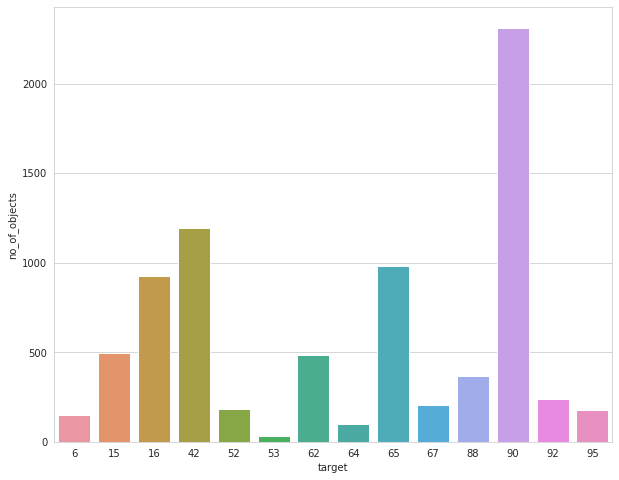

In [5]:
#Initial analysis of the training metadata.
all_targets = training_metadata.target.unique()
print("The {} targets are: ".format(len(all_targets)))
print(all_targets)

object_freq = pd.DataFrame(training_metadata.groupby("target", as_index = False)["object_id"].count())
object_freq = object_freq.rename(columns = {"object_id" : "no_of_objects"})
fig = plt.figure(figsize=(10, 8))
sns.barplot(x = object_freq.target, y = object_freq.no_of_objects)

Thus from the above histogram we see that most of the astronomical abjects belong to class 90, while we have fewer object belonging to class 53. We have to remember that class 99 is not present in the training data, but is included in the test data as "others". The imbalanced distribution also supports the randomness in the events in the Universe.

We move on to our next visulaization. We are going to primarily focus on the use of Galactic Coordinates for references here-on.

Text(0, 0.5, 'Galactical Latitude')

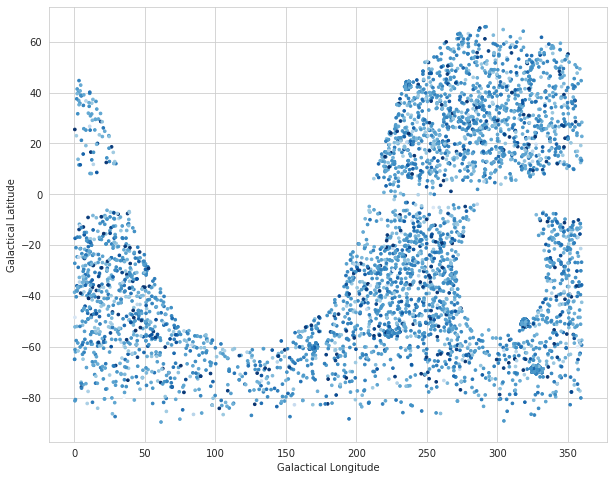

In [6]:
fig = plt.figure(figsize=(10,8))
fig = fig.add_subplot(111)
fig.scatter(training_metadata.gal_l,training_metadata.gal_b, c = training_metadata.distmod, s = 7, cmap = 'Blues');
fig.set_xlabel("Galactical Longitude", fontsize = 10)
fig.set_ylabel("Galactical Latitude", fontsize = 10)

The above graph suggest that the metric of distance of the astronomcal objects is pretty random with respect to the galactic co-ordinate system, which is consistent with the fact about an isotropic universe, that it looks same in all direction.

An idea about the distribution of the distmod for all the surveyed astronomical objects might give some meaningful insights.

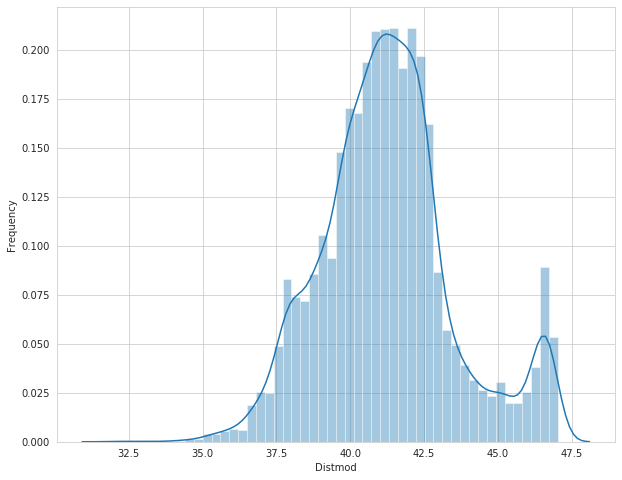

In [7]:
fig = plt.figure(figsize=(10,8))
sns.distplot(training_metadata[~np.isnan(training_metadata.distmod)].distmod);
plt.ylabel("Frequency", fontsize = 10);
plt.xlabel("Distmod", fontsize = 10);

Thus, the distribution is almost binomial, with a central peak at around 41 and another at 47, near its tail. That\'s with distmod. Let\'s see if the classes of the astronomical objects is somehow related to the Galactic Coordinates.

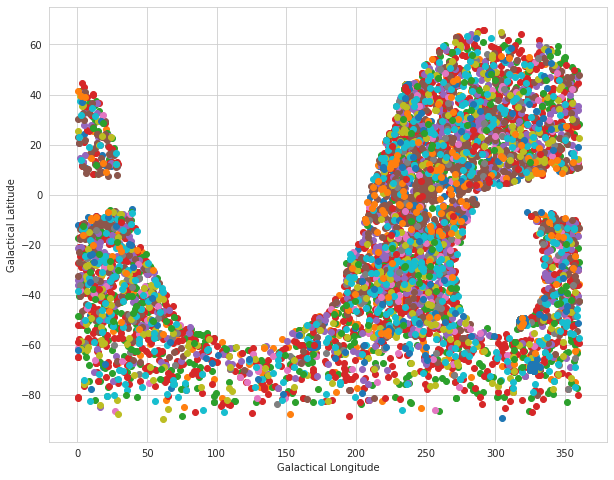

In [8]:
fig = plt.figure(figsize=(10,8))
fig = fig.add_subplot(111)
for class_target in all_targets:
    class_used = training_metadata[training_metadata.target == class_target]
    fig.scatter(x = class_used.gal_l, y = class_used.gal_b, alpha = 1)
plt.xlabel("Galactical Longitude", fontsize = 10)
plt.ylabel("Galactical Latitude", fontsize = 10);

We see that there is no particular relation between the clases and the co-ordinates and thus they are almost uniformly distributed across the universe (, specifically the surveyed portion).


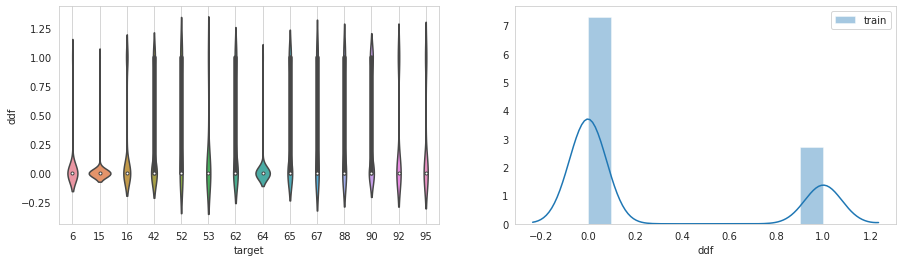

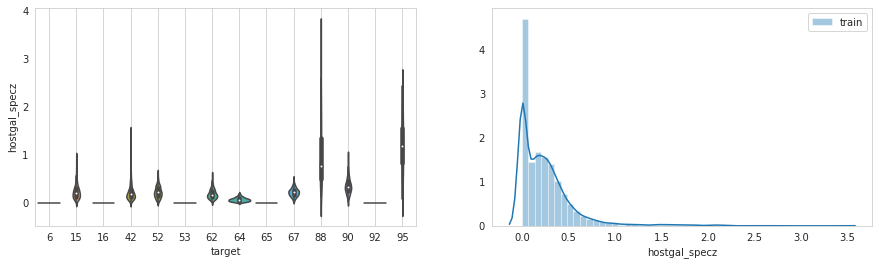

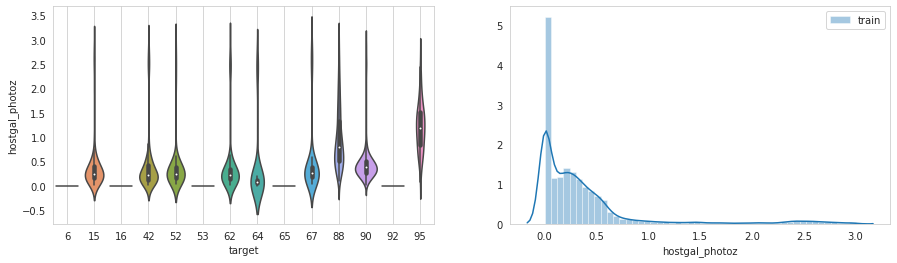

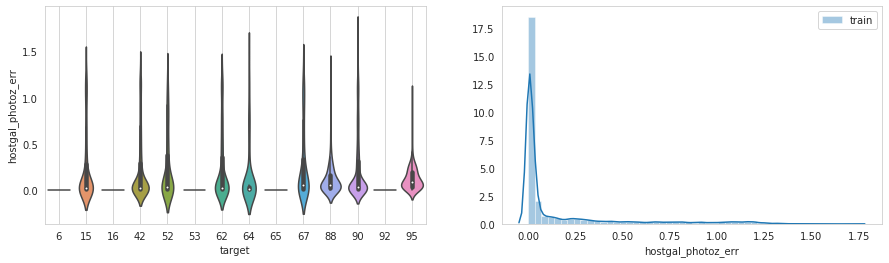

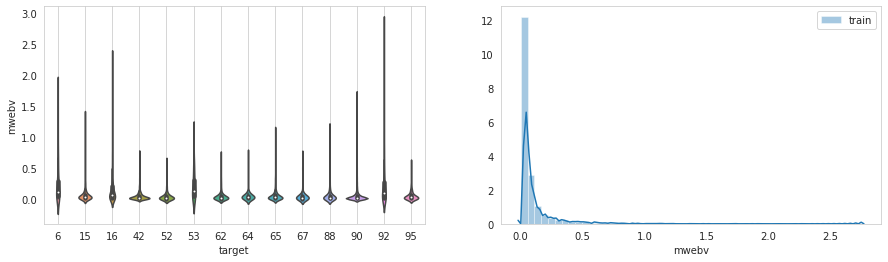

In [12]:
features_selected = ['ddf', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'mwebv']
for c in features_selected:
    plt.figure(figsize=[15, 4])
    plt.subplot(1, 2, 1)
    sns.violinplot(x='target', y=c, data=training_metadata)
    plt.grid()
    plt.subplot(1, 2, 2)
    sns.distplot(training_metadata[c].dropna())
    plt.legend(['train'])
    plt.grid()
    plt.show()

From the above plot, we see

Now, we focus on a pairplot of the attributes in the metadata set available.

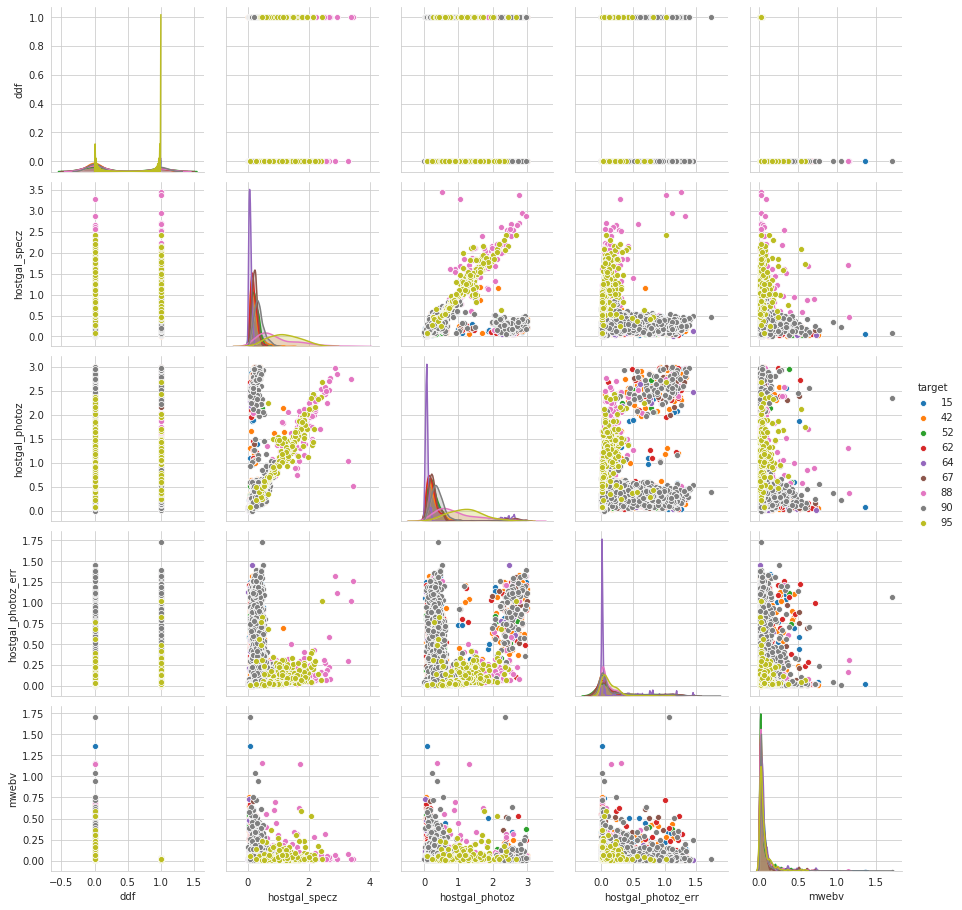

In [13]:
sns.pairplot(training_metadata.dropna(), hue='target', vars=features_selected)

#Performing PCA on our Dataset
We try to perform 2D visualization of the dataset using PCA. This, will probably give us a clear idea about the representation of the various classes distributed throughout the dataset.

First, we will omit few of the features that seems redundant. This include the co-ordinate of the objects with respect to both the latitude-longitude of the Earth and also, with respect to the galactic co-ordinate system used here. Thus we do not consider the features 

['ra', 'decl', 'gall', 'galb']

We are going to remove the 'object_id' attribute, as they are particular indications to each observation and the numbers do not convey any significant information. We also don't consider 'distmod' since it is some direct function transfromation of the 'hostgal_photoz' attribute.

Thus we are left with the attribute set:

['ddf_bool', 'hostgal_specz',	'hostgal_photoz',	'hostgal_photoz_err',	'mwebv']

We are going to standardize the remaining data to map it to an unit scale with mean = 0 and variance = 1.

The 'target' attribute will be our target output, divided into 14 classes.

In [14]:
print(training_metadata.isnull().sum())
training_metadata[training_metadata.distmod.isnull()].target.unique()

object_id                0
ra                       0
decl                     0
gal_l                    0
gal_b                    0
ddf                      0
hostgal_specz            0
hostgal_photoz           0
hostgal_photoz_err       0
distmod               2325
mwebv                    0
target                   0
dtype: int64


array([92, 65, 16,  6, 53])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

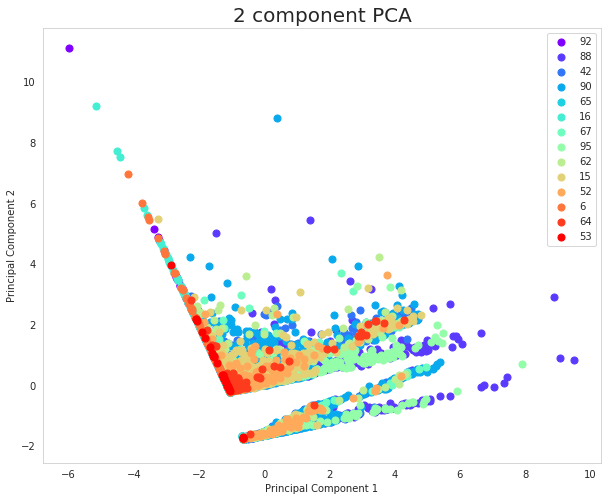

In [15]:
features_selected = ['ddf', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'mwebv']
input_data = training_metadata.loc[:, features_selected]
output_data = training_metadata.loc[:, 'target']

#Standardizing the feature values
input_data = StandardScaler().fit_transform(input_data)

#print(input_data)
#print(np.isnan(input_data))

#Perfoming PCA, projecting the 6 attributes to a 2 dimensional data
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(input_data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, output_data], axis = 1)

#Performing 2D data visualization
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('2 component PCA', fontsize = 20)
targets = all_targets
colors = cm.rainbow(np.linspace(0, 1, len(targets)))
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

Enough done with the metadata, lets bring the real deal together. We create a new dataframe to house bothe the light curve data and the metadata together corresponding to each astronomical objects.

#Simple Correlation Visualization
This is a simple attempt to plot the correlation between the attributes of the training_metadata dataset

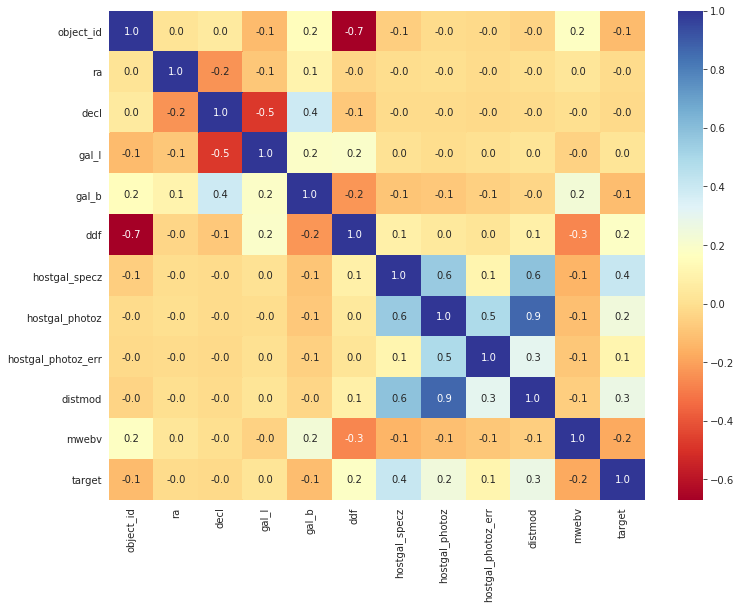

In [16]:
plt.figure(figsize=(12,9))
sns.heatmap(training_metadata.corr(), annot=True, fmt=".1f", cmap="RdYlBu")

In [17]:
training_main = training_data.merge(training_metadata, on = "object_id")
print(training_main.head())

   object_id         mjd  passband  ...  distmod  mwebv  target
0        615  59750.4229         2  ...      NaN  0.017      92
1        615  59750.4306         1  ...      NaN  0.017      92
2        615  59750.4383         3  ...      NaN  0.017      92
3        615  59750.4450         4  ...      NaN  0.017      92
4        615  59752.4070         2  ...      NaN  0.017      92

[5 rows x 17 columns]


Now, we can perform some more data visualzation with respect to the time series data that we have.

Lets see the effect of various attributes for a single astronomical object (say, object_id : 730), chosen randomly. We first see the variation of flux for each passband with respect to time. We already know, there are 6 passbands...

     object_id         mjd  passband  ...  distmod  mwebv  target
702        730  59798.3205         2  ...  40.2561  0.021      42
703        730  59798.3281         1  ...  40.2561  0.021      42
704        730  59798.3357         3  ...  40.2561  0.021      42
705        730  59798.3466         4  ...  40.2561  0.021      42
706        730  59798.3576         5  ...  40.2561  0.021      42

[5 rows x 17 columns]


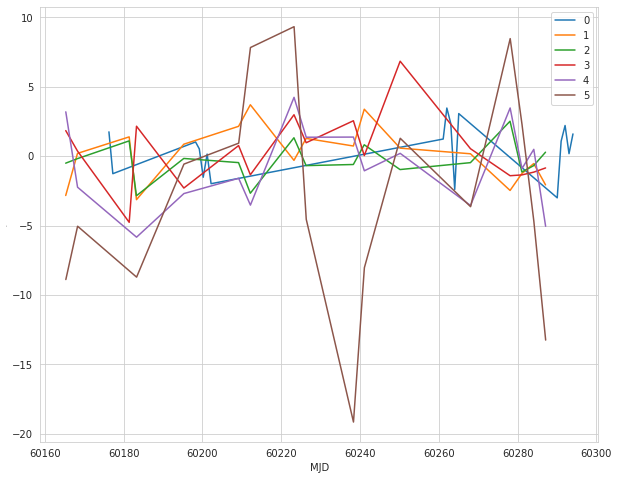

In [18]:
obj730_data = training_main[training_main.object_id == 730]
print(obj730_data.head())

obj730_data = obj730_data[(obj730_data.mjd > 60100) & (obj730_data.mjd<60300)]
fig = plt.figure(figsize=(10,8))
for passband in range(6):
  pb_data = obj730_data[obj730_data.passband == passband]
  plt.plot(pb_data.mjd, pb_data.flux, label = passband)
plt.xlabel("MJD", fontsize = 10)
plt.ylabel("flux", fontsize = 1)
plt.legend()

The peaks seem to occur almost near to each other for each passband. Now these pattern is different for extragalactic and galactic objects. Object ID 730 was an extragalactic object, beacose its hostgal_photoz value is not 0. Let's look at an 'galactic' object, say Object ID 615.

   object_id         mjd  passband  ...  distmod  mwebv  target
0        615  59750.4229         2  ...      NaN  0.017      92
1        615  59750.4306         1  ...      NaN  0.017      92
2        615  59750.4383         3  ...      NaN  0.017      92
3        615  59750.4450         4  ...      NaN  0.017      92
4        615  59752.4070         2  ...      NaN  0.017      92

[5 rows x 17 columns]


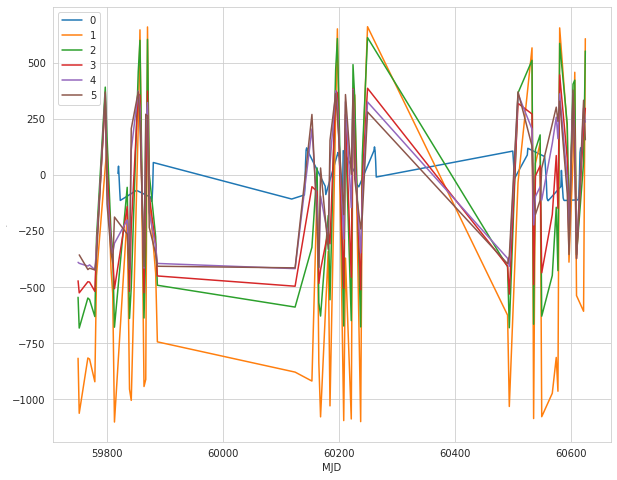

In [19]:
obj615_data = training_main[training_main.object_id == 615]
print(obj615_data.head())

obj730_data = obj615_data[(obj615_data.mjd > 59600) & (obj615_data.mjd<60300)]
fig = plt.figure(figsize=(10,8))
for passband in range(6):
  pb_data = obj615_data[obj615_data.passband == passband]
  plt.plot(pb_data.mjd, pb_data.flux, label = passband)
plt.xlabel("MJD", fontsize = 10)
plt.ylabel("flux", fontsize = 1)
plt.legend()

#Time Series Classification
Enough done with data visualization. We now have a clear idea of the variables to consider. Lets boil down to the code to perform the task of classification. The first implementation is a simple Neural Network implemented for the task. We shall add Recuurent Neural Network.

In [20]:
#Defining the function to convert the time-series data into a single row for each object.
def get_timeseries_by_column_name(train, passband, column_name):
    train_passband = train[train.passband == passband]
    ## This is where magic happens
    train_column_timeseries = train_passband.groupby(['object_id', 'passband'])[column_name].apply(lambda df: df.reset_index(drop=True)).unstack()
    train_column_timeseries.fillna(0, inplace=True)
    train_column_timeseries  = train_column_timeseries.reset_index()
    train_column_timeseries['feature_id'] = column_name
    return train_column_timeseries

def get_timeseries(train, passband):
    df = pd.concat([get_timeseries_by_column_name(train, passband, column_name) for column_name in ['mjd', 'flux', 'flux_err', 'detected']])
    df = df.sort_values(['object_id', 'passband'])
    return df

#Standardising the variables
ss = StandardScaler()
training_data[['mjd', 'flux', 'flux_err']] = ss.fit_transform(training_data[['mjd', 'flux', 'flux_err']])
#train.head()

train_list = []
for passband in range(0, 6):
    train_passband =  get_timeseries(training_data, passband=passband)
    train_list.append(train_passband)
    print("train_list[%d]" % passband, train_list[passband].shape)

train_list[0] (31392, 75)
train_list[1] (31392, 61)
train_list[2] (31392, 61)
train_list[3] (31392, 61)
train_list[4] (31392, 61)
train_list[5] (31392, 60)


In [21]:
num_features = len(['mjd', 'flux', 'flux_err', 'detected'])
drop_features= [ "feature_id", "object_id", "passband"]
X_train_list = []
for passband in range(0, 6):
    num_columns = len(train_list[passband].columns) - len(drop_features)
    print("num_columns[%d]:" % passband, num_columns)
    X_train_list.append(train_list[passband].drop(drop_features, axis=1).values.reshape(-1, num_features, num_columns).transpose(0, 2, 1))
    print("X_train_list[%d].shape:" % passband, X_train_list[passband].shape)

num_columns[0]: 72
X_train_list[0].shape: (7848, 72, 4)
num_columns[1]: 58
X_train_list[1].shape: (7848, 58, 4)
num_columns[2]: 58
X_train_list[2].shape: (7848, 58, 4)
num_columns[3]: 58
X_train_list[3].shape: (7848, 58, 4)
num_columns[4]: 58
X_train_list[4].shape: (7848, 58, 4)
num_columns[5]: 57
X_train_list[5].shape: (7848, 57, 4)


In [22]:
classes = sorted(training_metadata.target.unique())
class_map = dict()
for i,val in enumerate(classes):
    class_map[val] = i

merged_train = train_list[0][train_list[0].feature_id == 'flux'].merge(training_metadata, on='object_id', how='left')
merged_train = merged_train.drop(['ra',	'decl',	'gal_l',	'gal_b',	'ddf',	'hostgal_specz',	'hostgal_photoz',	'hostgal_photoz_err',	'distmod',	'mwebv'], axis=1)
#merged_train.head()

targets = merged_train.target
target_map = np.zeros((targets.shape[0],))
target_map = np.array([class_map[val] for val in targets])
Y = to_categorical(target_map)
Y.shape

(7848, 14)

In [0]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

In [0]:
n_classes = len(classes)

def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

def build_model():
    def basic_layer(input_):
        output = GRU(64, kernel_initializer=weight_variable, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)(input_)
        output = Dropout(0.5)(output)
        output = GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(output)
        output = GRU(16, dropout=0.5, recurrent_dropout=0.5)(output)
        output = Dense(32)(output)
        return output
    
    # Keras functional API supports multiple inputs!
    input0 = Input(shape=(None, num_features), dtype='float32', name='passband0')
    input1 = Input(shape=(None, num_features), dtype='float32', name='passband1')
    input2 = Input(shape=(None, num_features), dtype='float32', name='passband2')
    input3 = Input(shape=(None, num_features), dtype='float32', name='passband3')
    input4 = Input(shape=(None, num_features), dtype='float32', name='passband4')
    input5 = Input(shape=(None, num_features), dtype='float32', name='passband5')
    
    merged_output = concatenate([basic_layer(input0),basic_layer(input1),basic_layer(input2),basic_layer(input3),basic_layer(input4),basic_layer(input5)])
    merged_output = Dense(64)(merged_output)
    final_output = Dense(len(classes), activation='softmax')(merged_output)
    return Model(inputs=[input0, input1, input2, input3, input4, input5], outputs=[final_output])

In [0]:
y_count = Counter(target_map)
wtable = np.zeros((len(classes),))
for i in range(len(classes)):
    wtable[i] = y_count[i] / target_map.shape[0]

In [0]:
batch_size = 512
y_map = target_map
y_categorical = Y
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
oof_preds = np.zeros((len(X_train_list[0]), len(classes)))
epochs = 10 #5000

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint('./keras.model',monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    X0 = X_train_list[0]
    X1 = X_train_list[1]
    X2 = X_train_list[2]
    X3 = X_train_list[3]
    X4 = X_train_list[4]
    X5 = X_train_list[5]
    x_train0, x_train1, x_train2, x_train3, x_train4, x_train5, y_train = X0[trn_], X1[trn_], X2[trn_], X3[trn_], X4[trn_], X5[trn_], y_categorical[trn_]
    x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5, y_valid = X0[val_], X1[val_], X2[val_], X3[val_], X4[val_], X5[val_], y_categorical[val_]
    
    model = build_model()    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)#
    early_stopping = EarlyStopping(monitor='loss', patience=30, verbose=1)
    model.compile(loss=mywloss, optimizer=optimizer, metrics=['accuracy'])
    history = model.fit([x_train0, x_train1, x_train2, x_train3, x_train4, x_train5], y_train,
                    validation_data=[[x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5], y_valid], 
                    epochs=epochs, batch_size=batch_size, shuffle=True,verbose=1,callbacks=[checkPoint, early_stopping])      
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict([x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5],batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict([x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5],batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))


The RNN seems to run into compatibility issue with Tensorflow version. We will try to implement a simple Neural Network for the task of classification, for now.

In [0]:
#Defining the required data again for clarity

full_train = training_data.reset_index().merge(right=training_metadata, how='outer', on='object_id')

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new) 

In [0]:
#WE have the multi_weighted_logloss() and mywloss() already defined. We define the function for implementing a simple NN model here
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










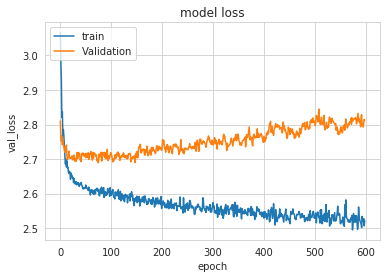

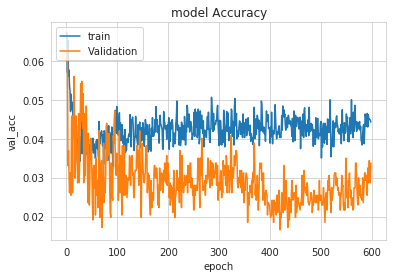

Loading Model


ValueError: ignored

In [33]:
#We also have the class_map and the target values defined, Y (categorical values), and the function to plot the loss and accuracy change with training
y_categorical = Y

#Beginning the training of all the models
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('Multi Weighted Log Loss : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))